# Modeling Bacteria

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage.filters import laplace
import copy

In [2]:
# stole from https://stackoverflow.com/questions/67970477/compute-divergence-with-python/67971515#67971515
# DOUBLE CHECK THAT THIS WORKS, maybe ask professor?
def divergence(f):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])

## Non-Linear Diffusion Model (NLDm)
Simplier model (with certain assumptions)

Check first bacterial model paper for equations and assumptions

In [3]:
# ==========CONSTANTS====================
#   D0: honestly idk what this one means but the paper basically only uses D0 = .1
#      It's some thing about a diffusion field
#   mu: death rate of bacteria, paper uses mu = 0.01 to 0.25, uses 0.15 as baseline
#   k: also unsure as to the meaning of this one, but paper only uses k = 1
#   t: amount of time between timesteps in seconds, no info on this in paper
#   num_updates: total number of updates
#      note: total time of simulation is t * num_updates
#      another note: 30 minutes is 1800 seconds
#   update_interval: number of intervals to do before each image update
D0 = 0.1
mu = 0.15
k = 1
t = 0.1
num_updates = 100
update_interval = 1

In [4]:
# NLDm Model updates
# parameter inputs are the same for all functions:
#   b: bacterial field matrix
#   n: nutritional field matrix
#   s: sporlation field matrix

# DOUBLE CHECK THAT PAPER USES EULER'S METHOD
def NLDmBacteria(b, n):
    # updates the bacterial field
    nb = np.matmul(n, b)
    mub = mu * b
    gradb = np.gradient(b)
    D0b = D0 * (b**k) # this may be issue
    termToBeDiv = np.matmul(D0b, gradb) # this should be matrix mul
    finalTerm = divergence(termToBeDiv) + nb - mub
    return b + (finalTerm * t)

# issue might be that n < 0 is possible, may be why wild negative values are possible
# also may be an issue for other fields
def NLDmNutrients(b, n):
    # updates the nutrient field
    lapn = laplace(n)
    bn = np.matmul(b, n) # this may be problem, it switches order from what bacteria field update does 
    return n + ((lapn - bn) * t)

def NLDmSporlation(b, s):
    # updates the sporelation field
    mub = mu * b
    return s + (mub * t)

'''
# doesn't work yet
def circular_mask(A):
    # applies a circular mask to each field to keep it in the petri dish
    # if something wanders out, just destroy it
    radius = A.shape[0]  # A should be square anyway
    a, b = radius/2, radius/2  # center of circle
    y,x = np.ogrid[-a:radius-a, -b:radius-b]
    mask = x**2 + y**2 <= radius**2
    return A[mask]
'''

def no_neg(A):
    # edits the matrix directly
    A[A < 0] = 0

In [5]:
# helper function for below, makes the circle for bacterial field
#   N: size of square matrix to populate with values
#   center_amount: the amount of bacteria
def start_bac(N, center_amount):
    b = np.zeros((N, N))
    # pretty suboptimal solution to this problem but eh
    min_val = max(center_amount / 20, 1)  # arbitrary stopping point
    for x in range(N):
        for y in range(N):
            # the below equation is the equation for a disk that is most concentrated
            # at the center and disperses
            value = center_amount - (x - N/2)**2 - (y - N/2)**2
            if value < min_val:
                value = 0
            b[x][y] = value
    return b

# NLDm starting conditions
# Makes a NxN starting matrix and populates the fields with:
#   s: sporlation field (dead cells) starting with 0
#   n: nutrition field, constant throughout with n0
#   b: bacterial field, circle with center value of b0
#        (note radius will depend on b0, not sure if there is a formula to find the radius from b0)
#        (from random testing, seems like b0 = 4N allows for about 1/4 radius)
def start_fields(N, n0, b0):
    s = np.zeros((N, N))  # sporelation field, all starts at 0
    n = np.ones((N, N))
    n = n0 * n  # nutrition field, just constant field
    # n = circular_mask(n)
    b = start_bac(N, b0)
    return b, n, s

In [6]:
# draws a field (stole from github)
def draw(A, title):
    """draw the concentrations"""
    fig, ax = plt.subplots()
    im = ax.imshow(A)
    ax.set_title(title)
    fig.colorbar(im)
    plt.show()
    plt.close()

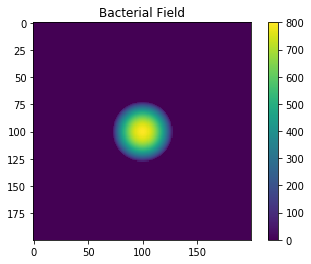

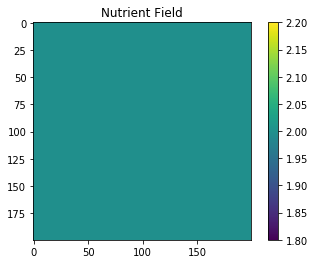

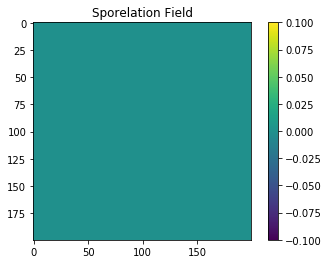

In [7]:
# sets up the fields
bac, nutr, spore = start_fields(200, 2, 800)
draw(bac, 'Bacterial Field')
draw(nutr, 'Nutrient Field')
draw(spore, 'Sporelation Field')

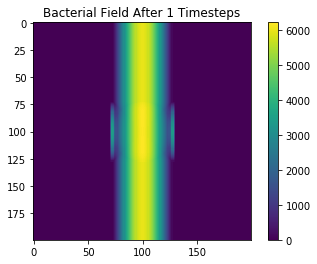

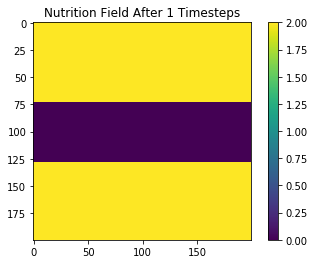

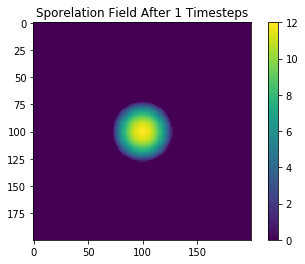

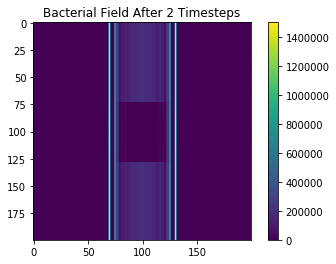

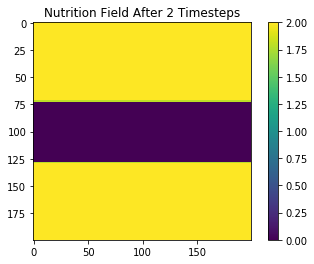

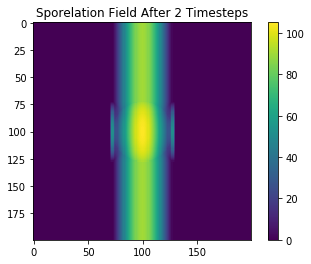

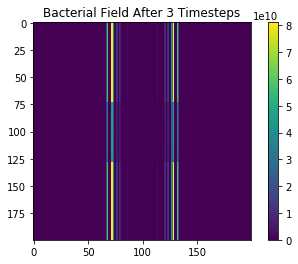

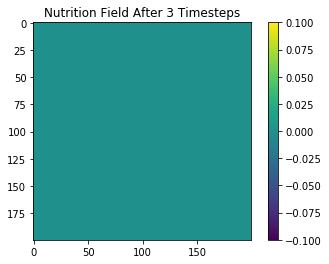

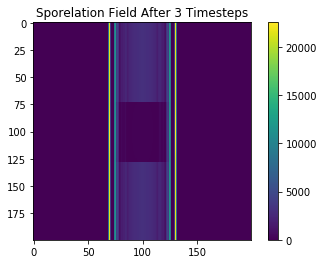

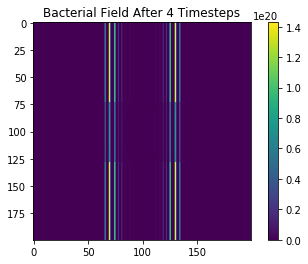

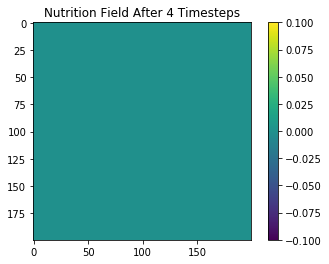

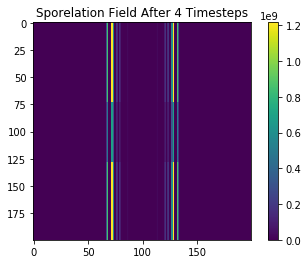

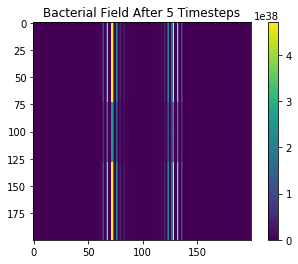

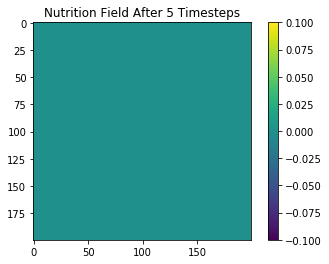

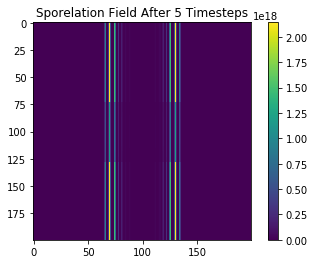

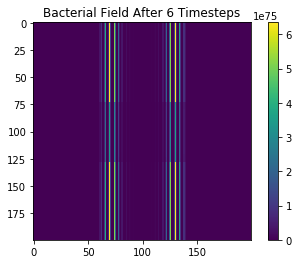

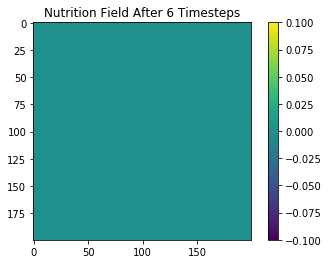

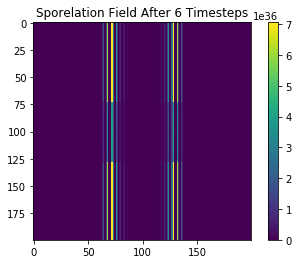

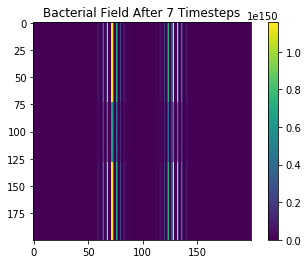

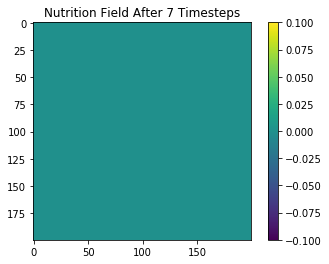

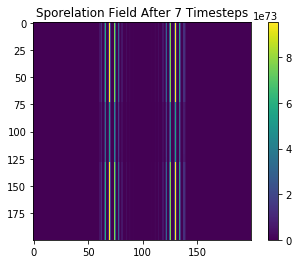

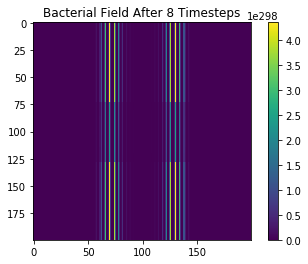

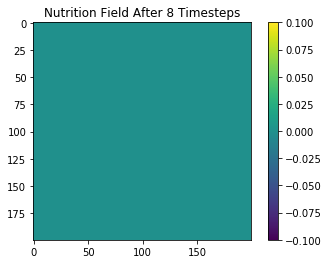

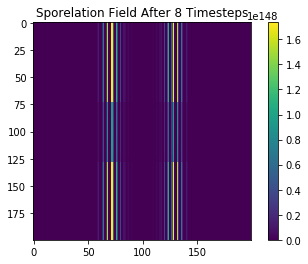

C:\Users\mattp\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1068: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\mattp\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1089: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
C:\Users\mattp\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1096: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


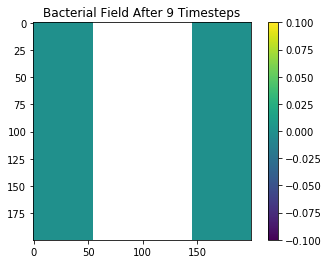

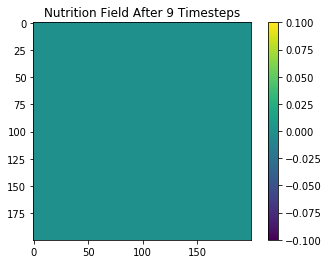

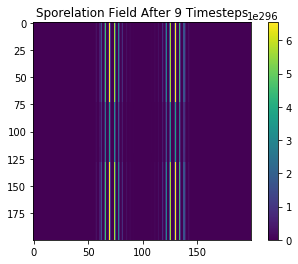

C:\Users\mattp\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
C:\Users\mattp\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in matmul


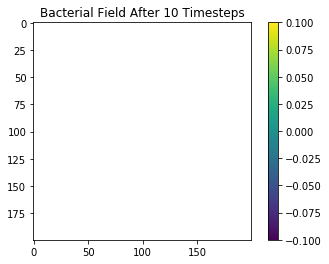

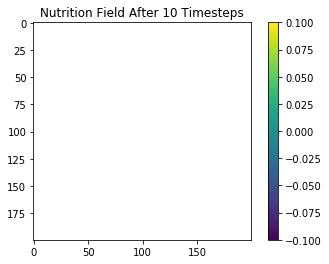

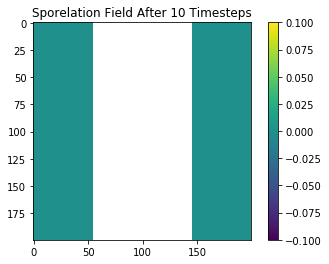

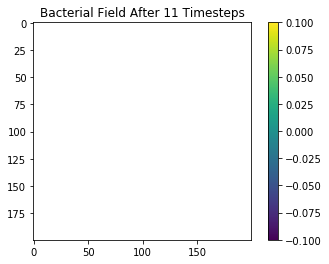

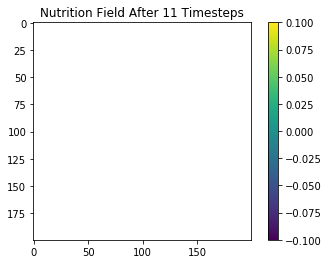

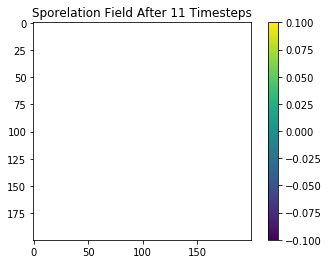

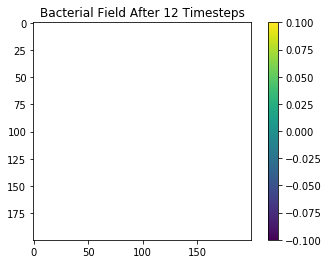

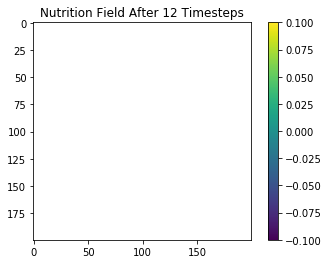

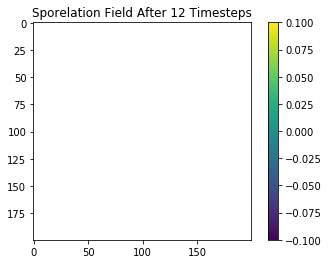

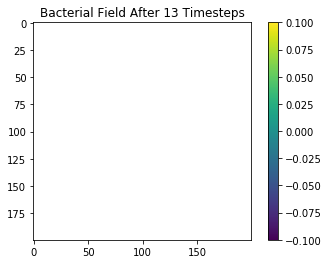

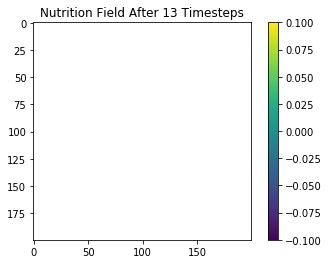

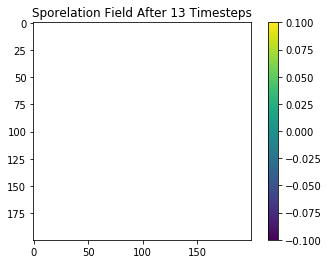

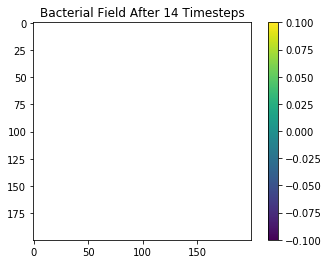

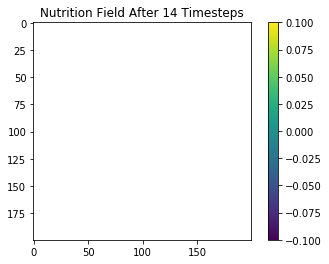

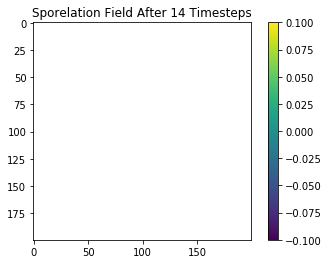

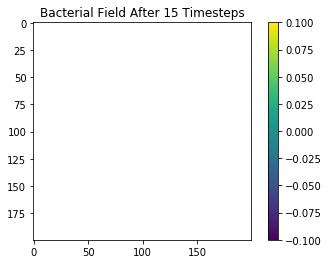

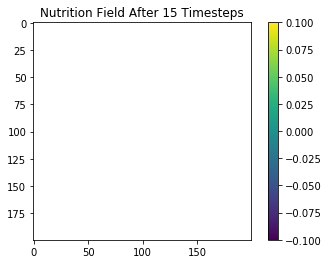

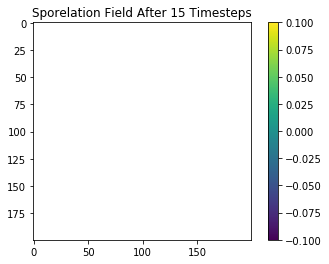

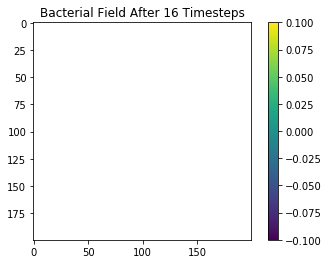

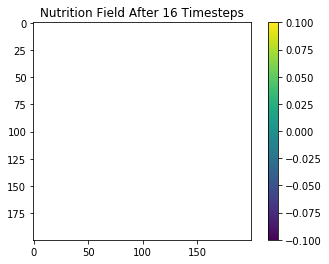

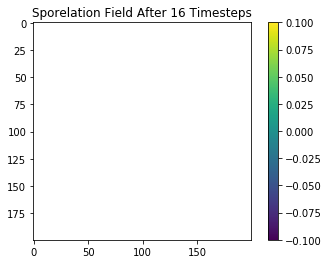

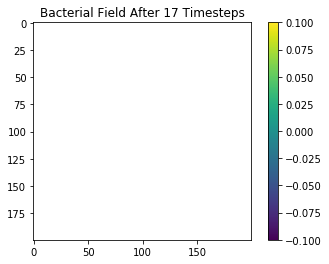

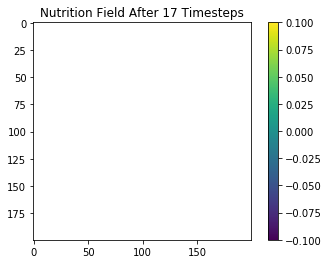

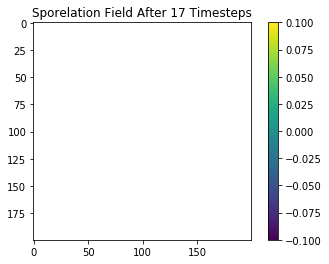

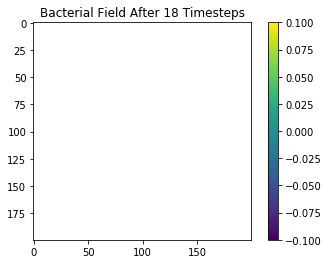

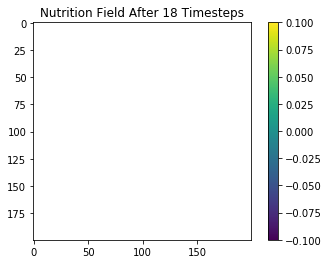

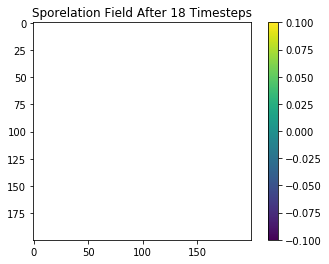

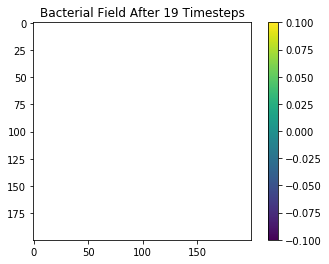

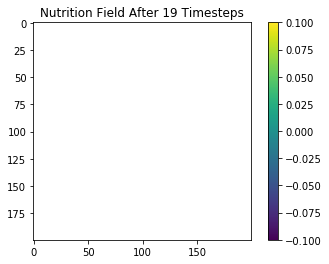

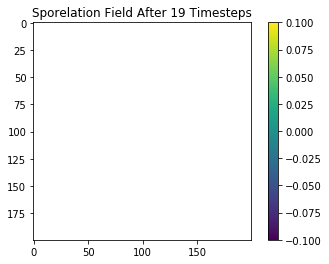

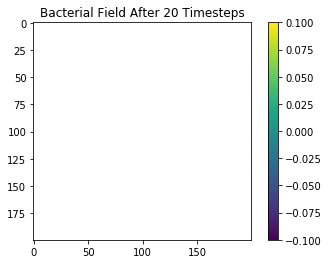

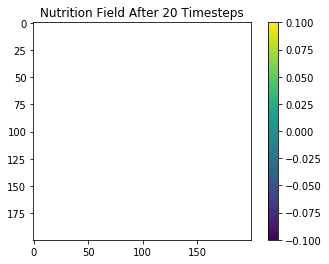

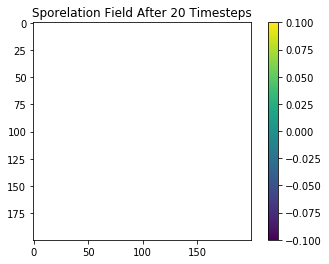

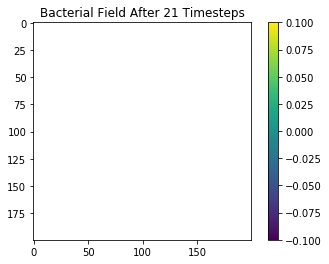

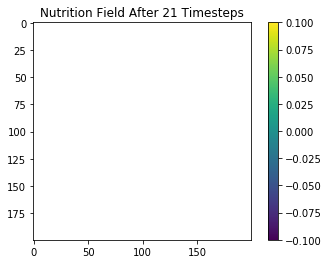

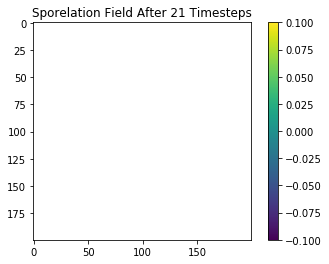

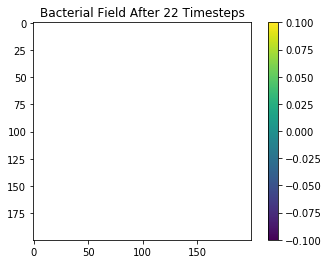

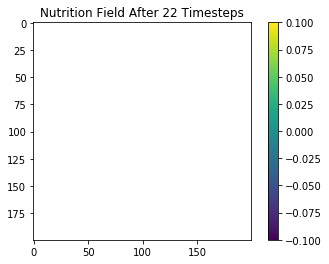

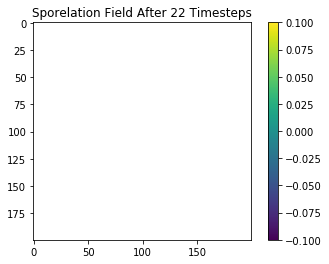

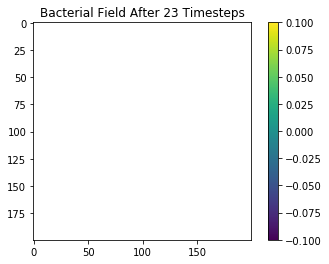

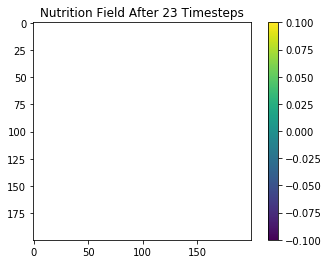

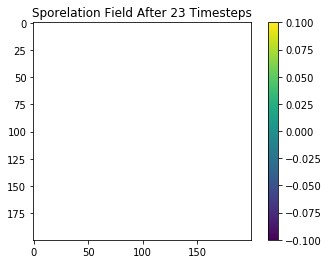

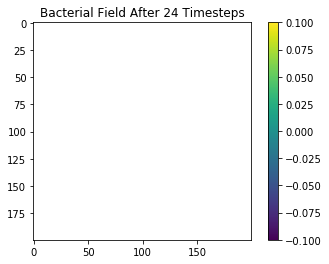

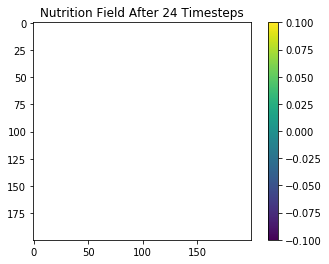

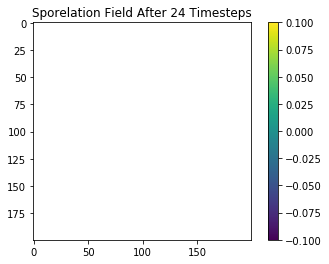

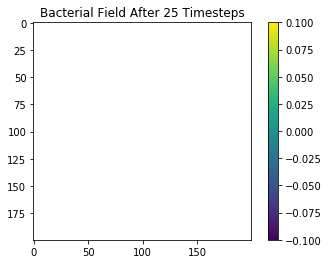

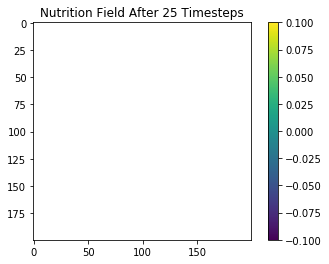

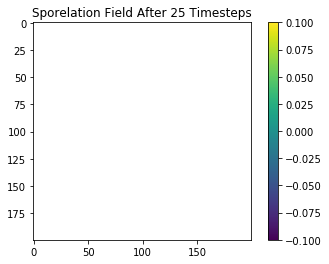

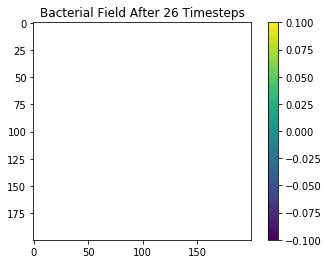

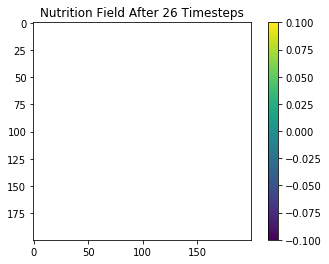

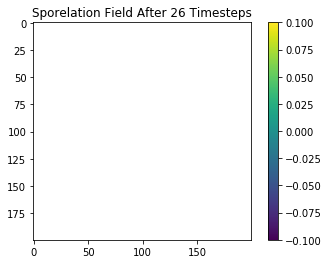

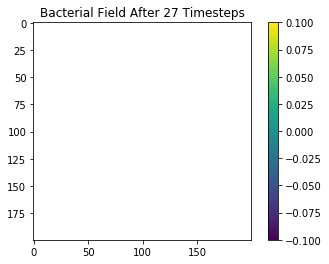

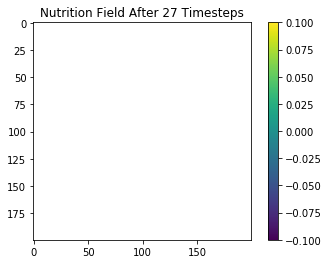

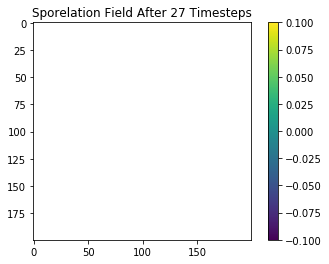

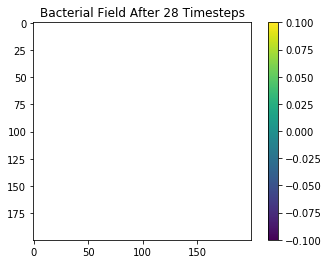

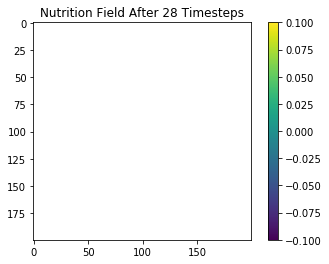

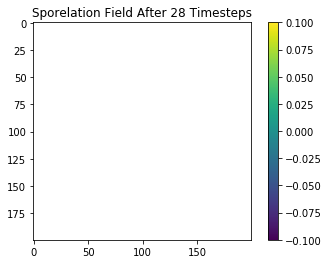

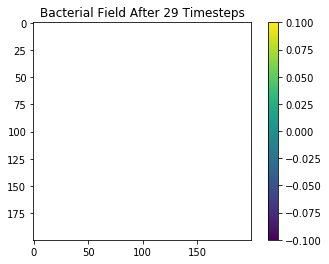

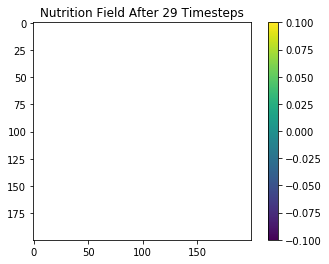

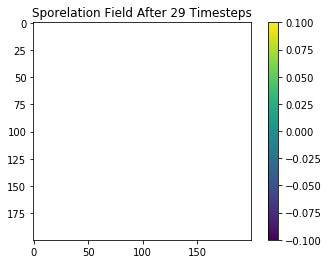

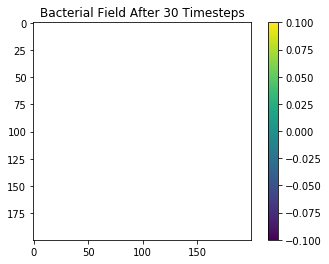

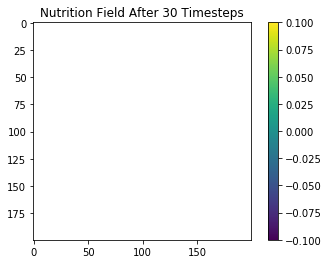

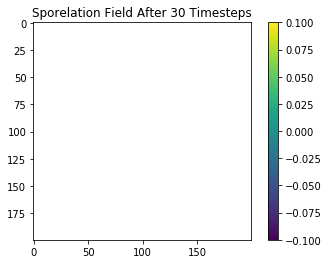

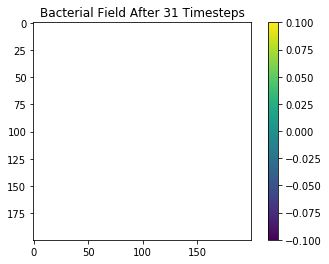

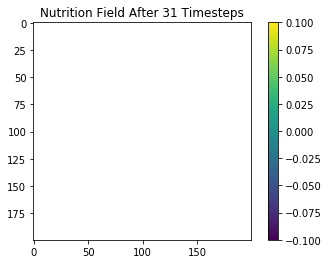

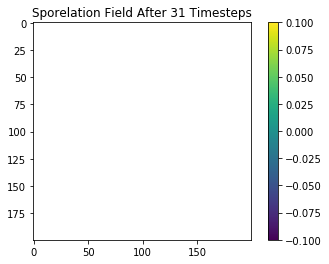

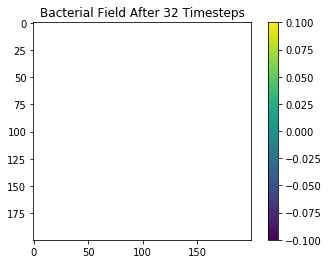

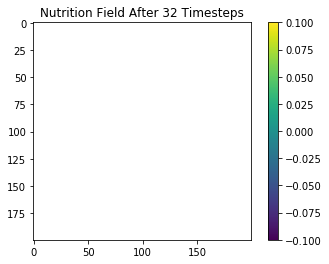

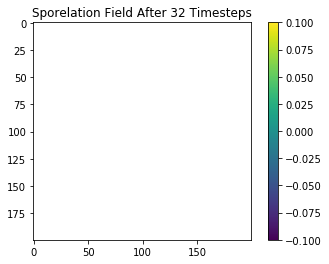

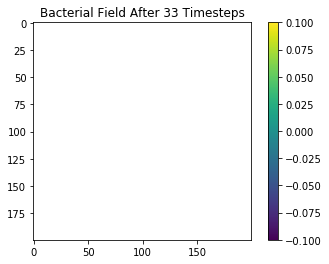

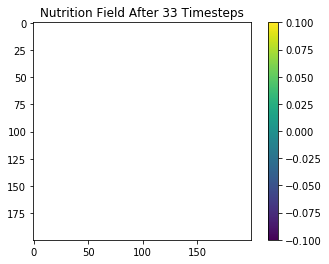

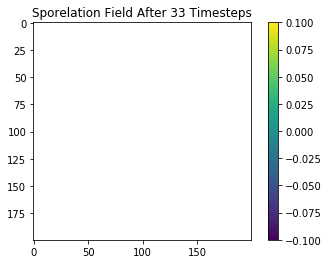

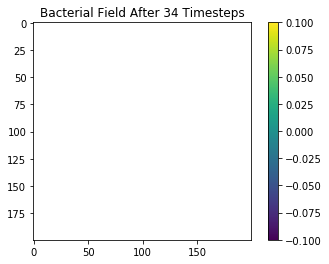

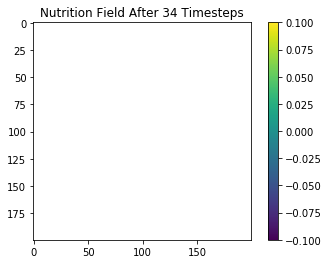

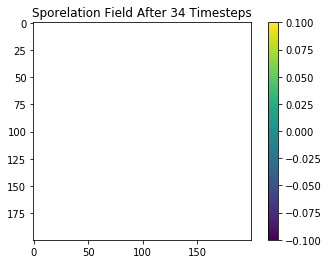

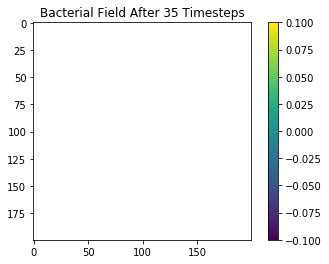

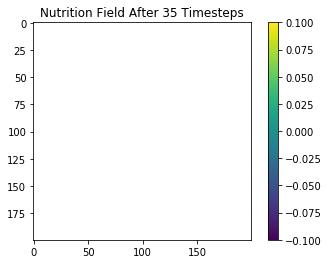

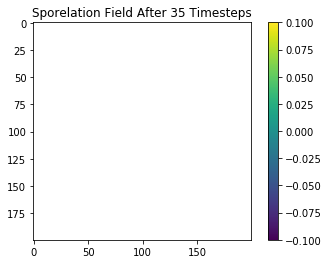

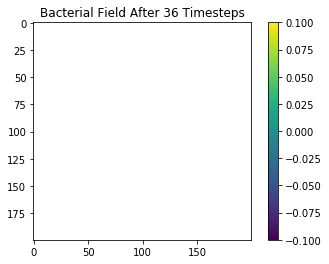

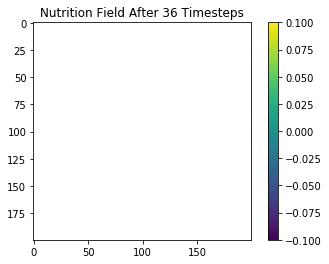

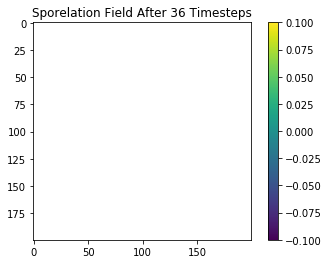

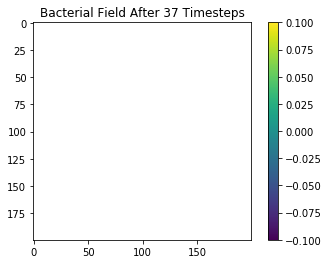

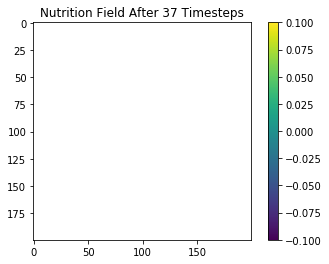

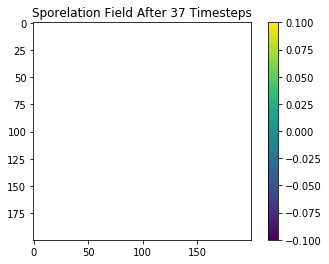

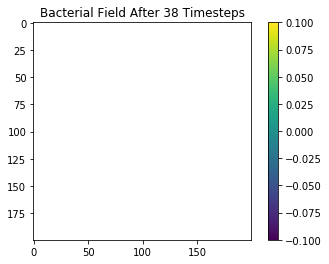

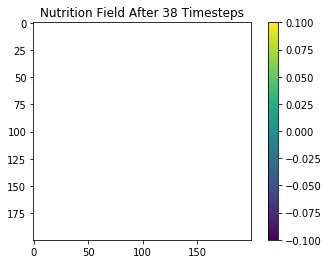

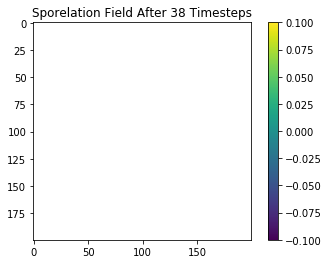

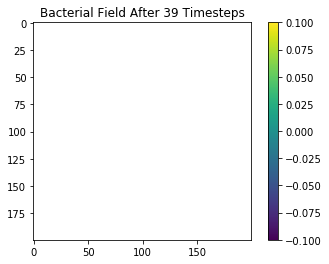

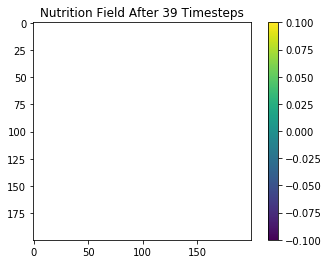

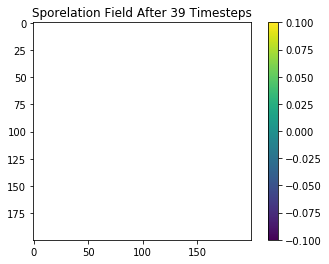

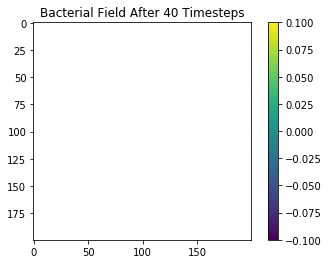

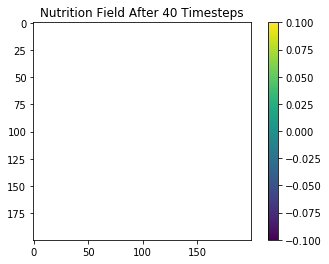

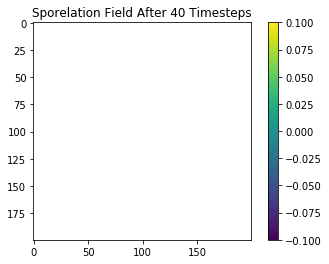

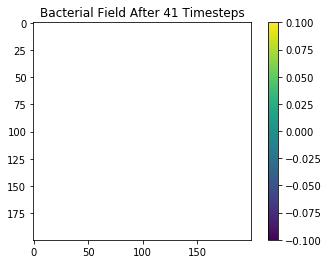

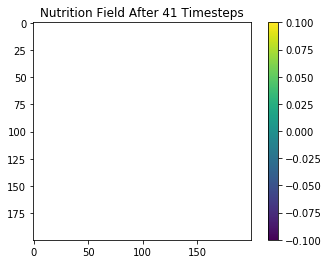

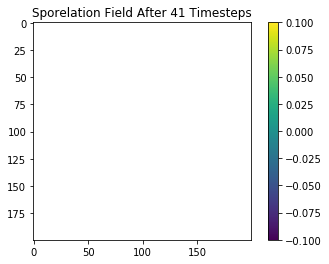

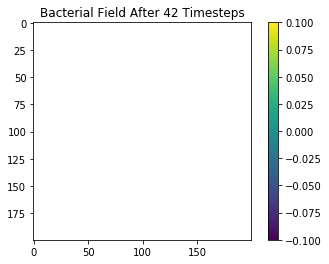

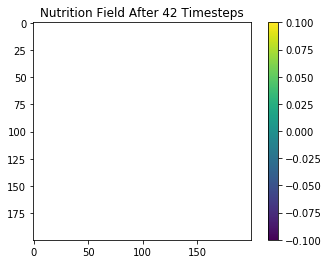

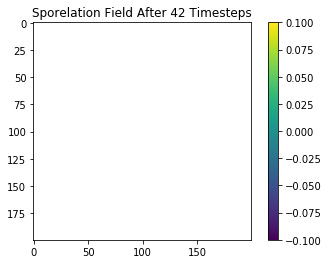

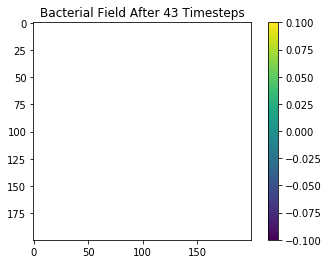

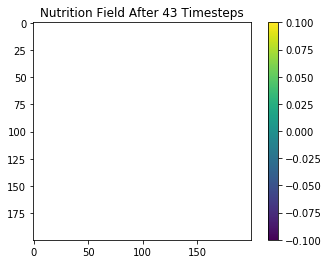

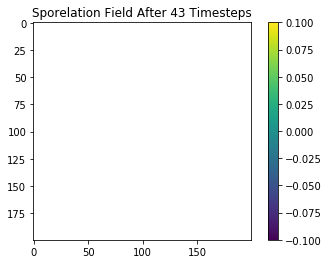

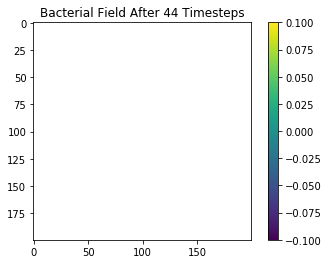

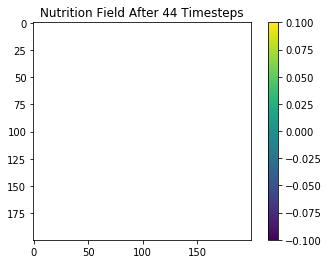

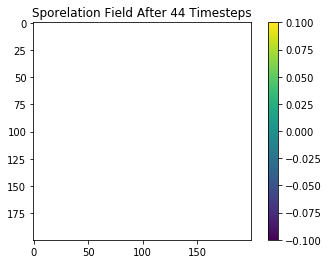

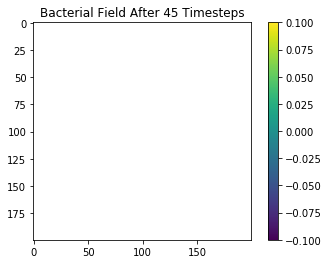

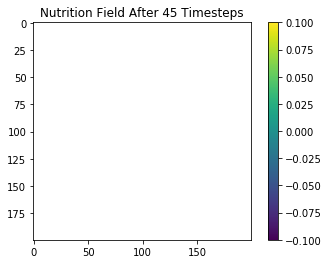

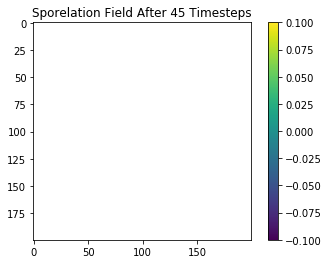

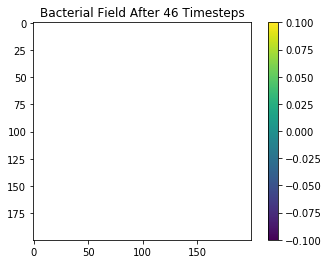

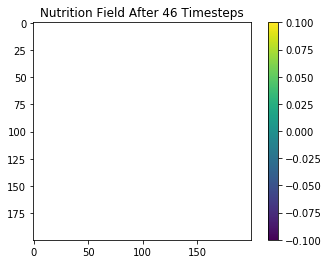

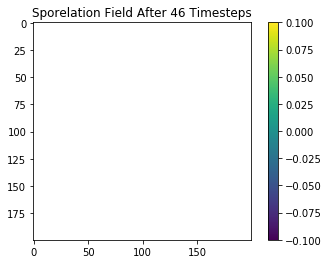

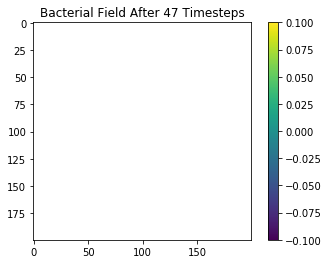

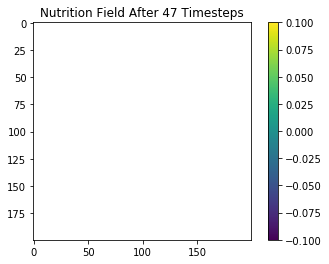

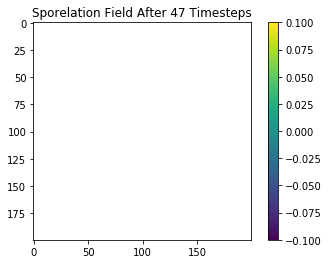

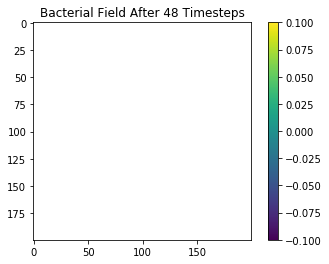

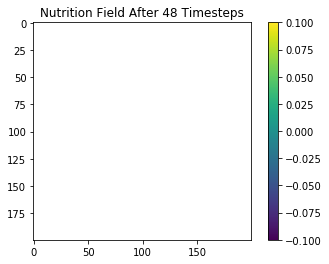

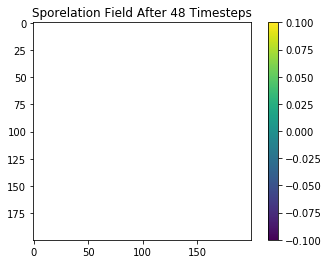

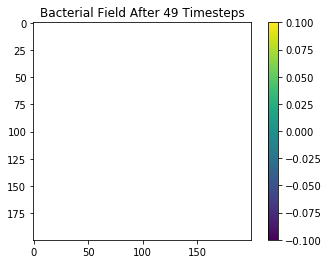

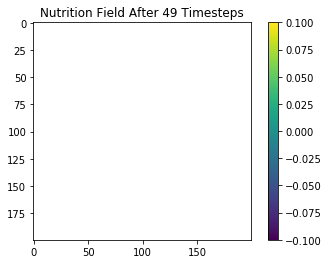

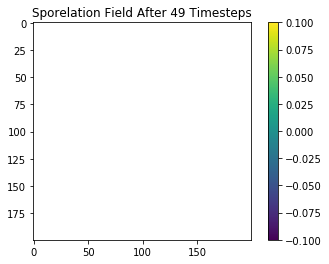

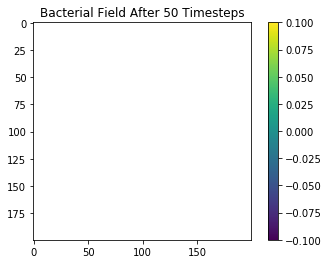

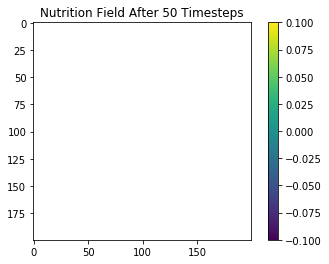

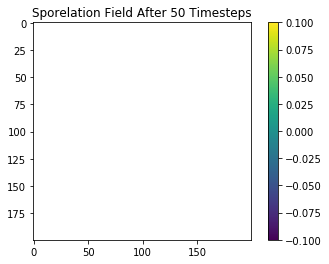

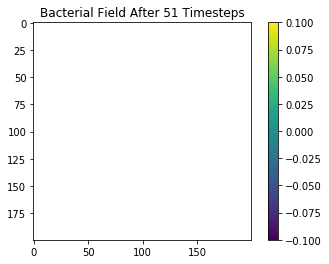

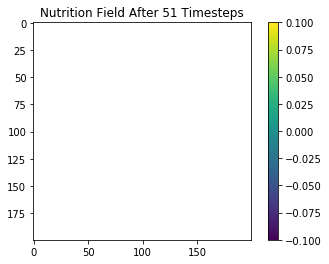

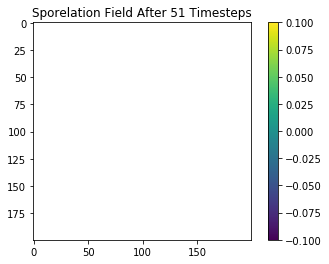

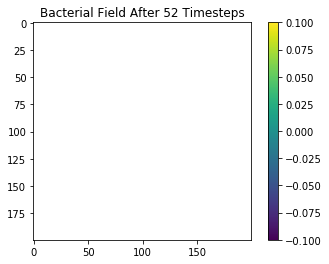

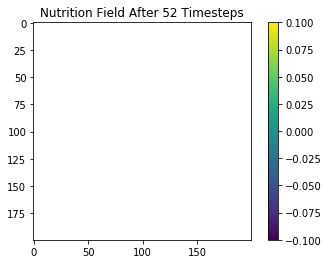

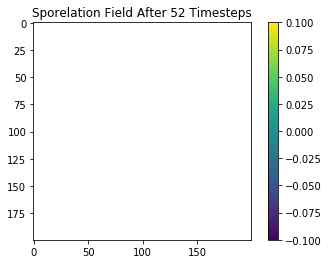

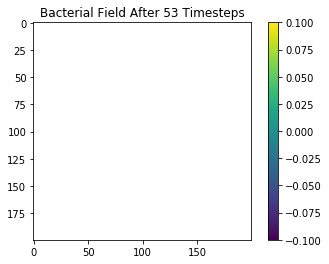

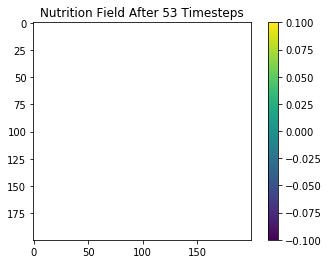

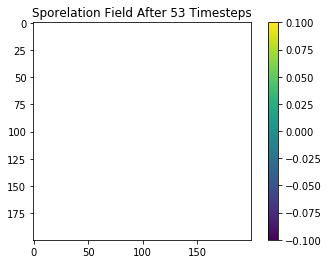

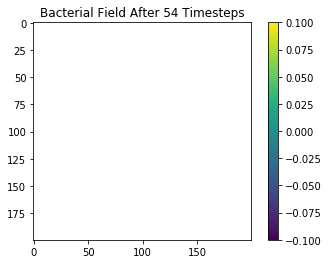

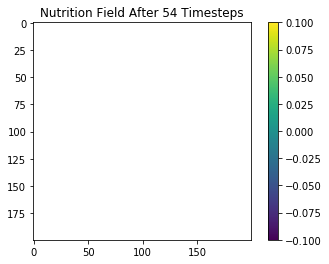

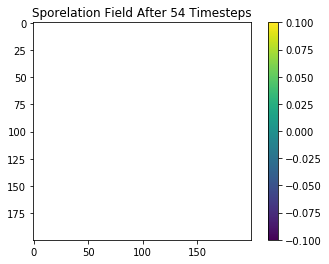

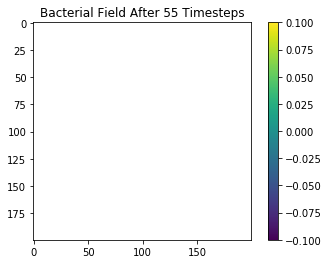

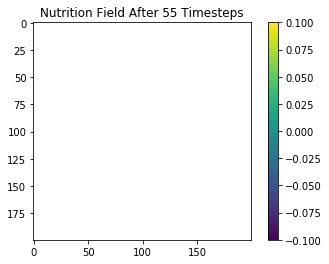

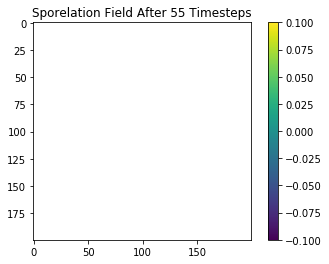

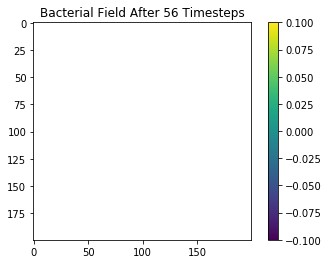

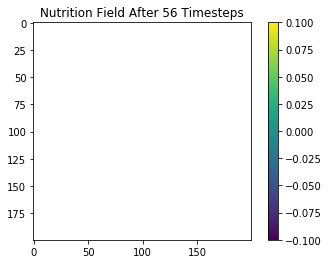

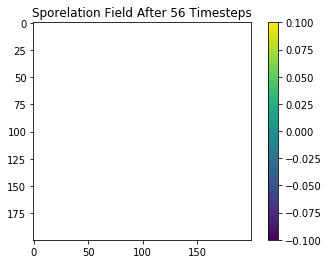

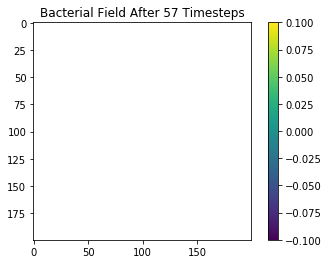

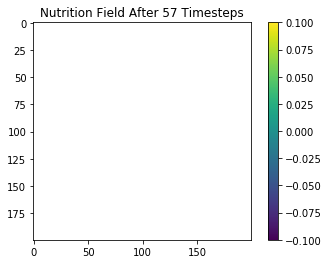

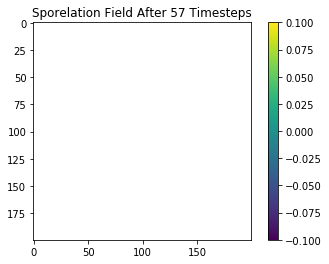

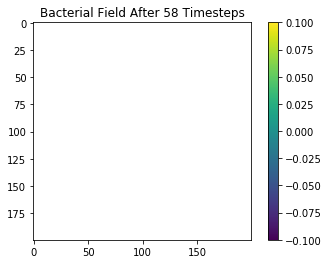

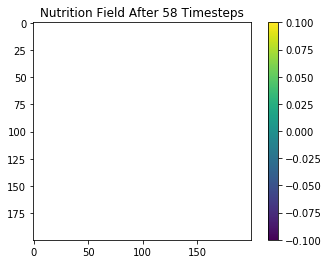

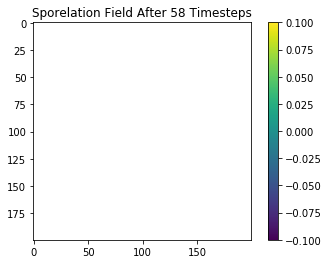

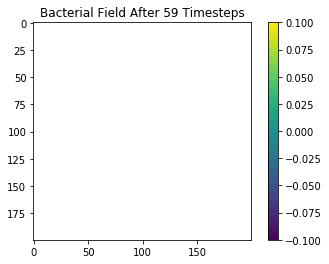

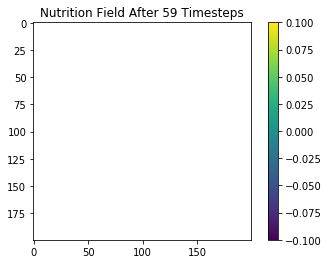

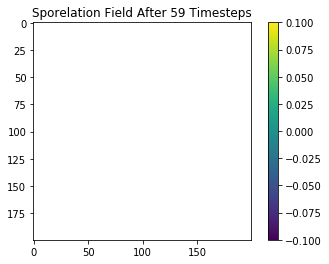

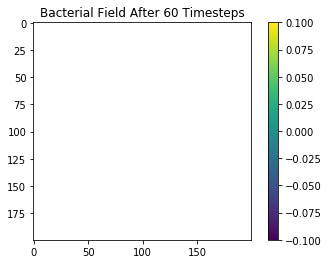

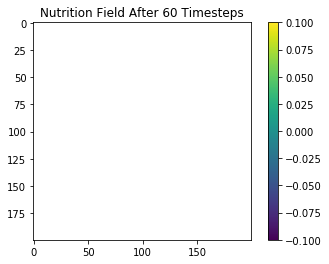

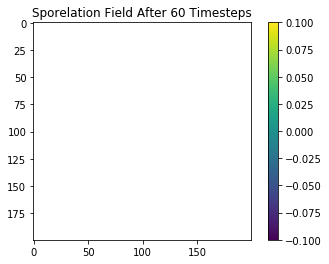

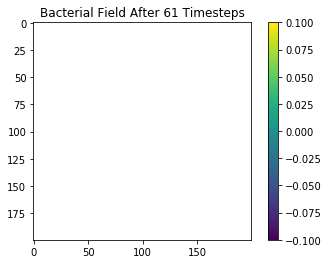

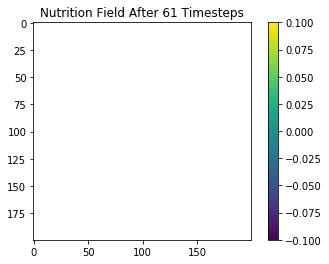

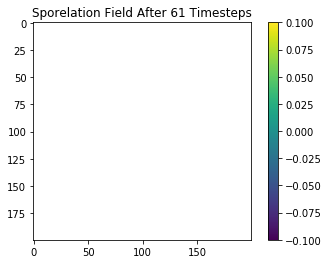

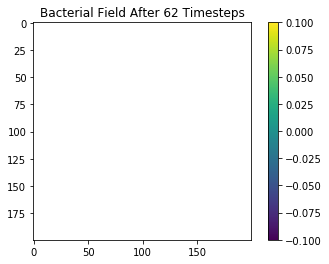

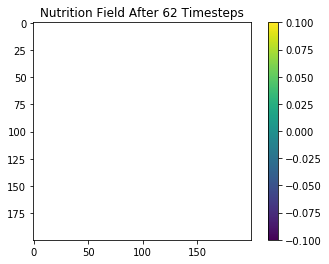

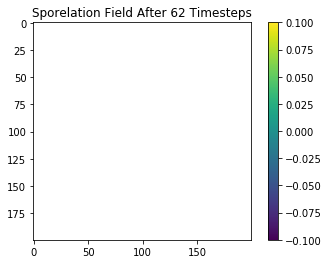

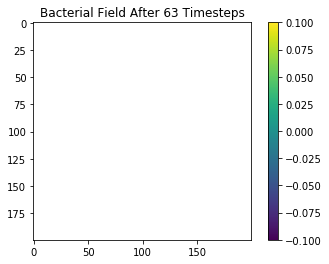

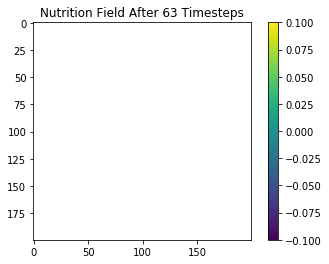

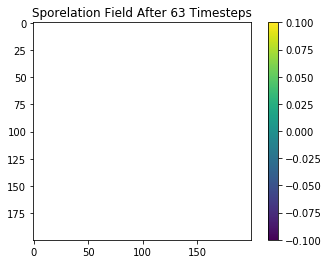

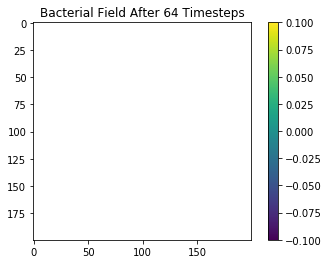

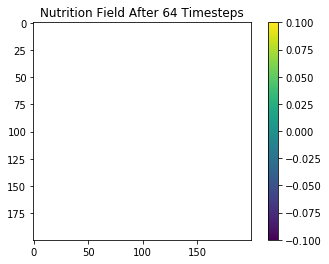

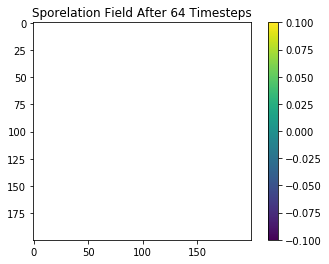

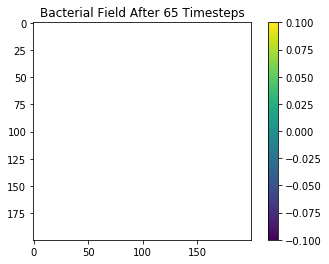

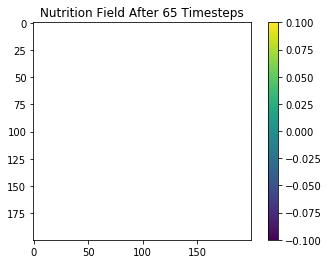

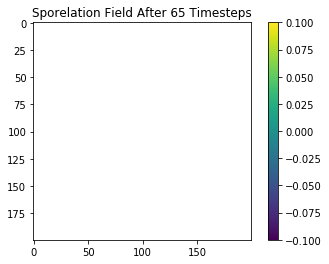

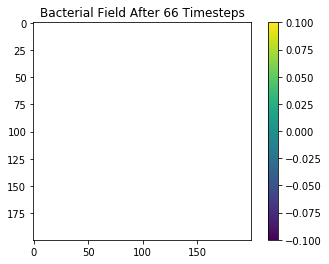

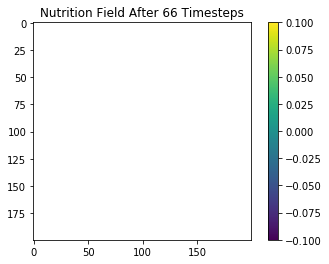

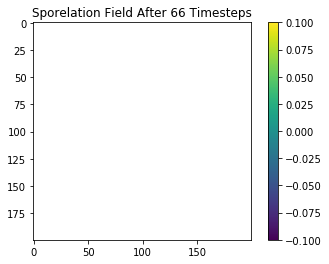

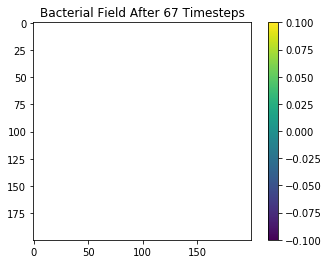

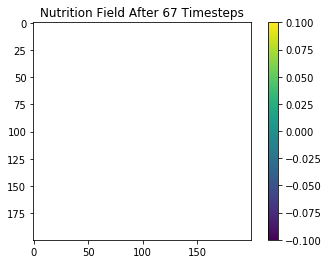

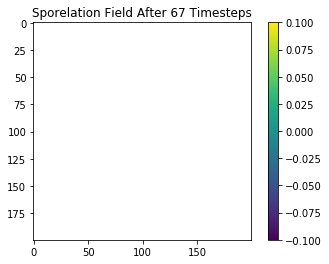

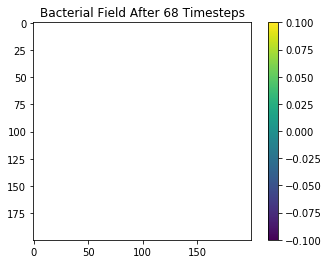

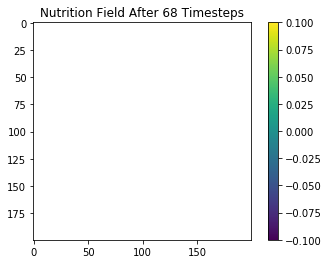

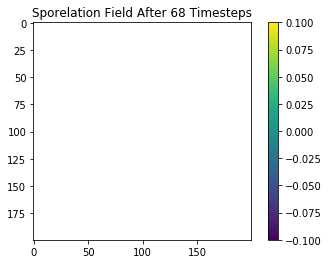

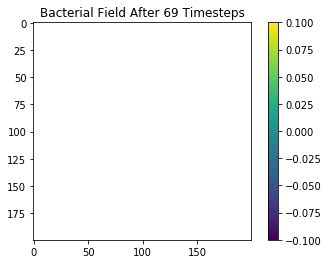

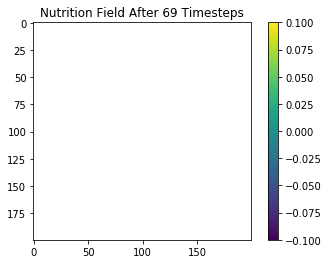

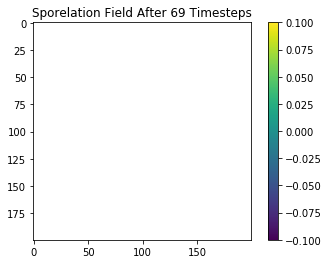

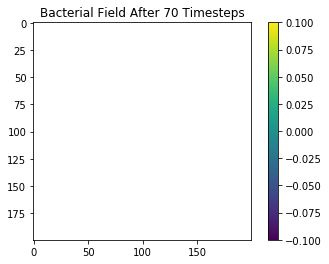

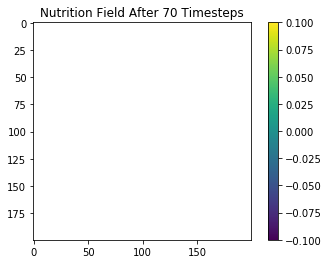

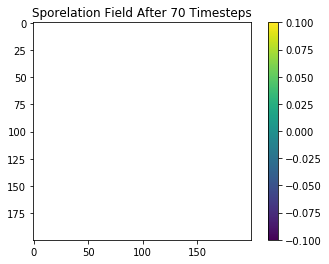

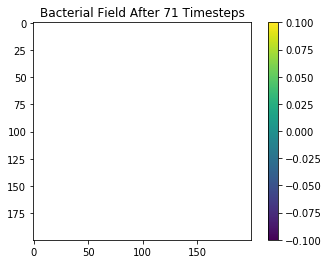

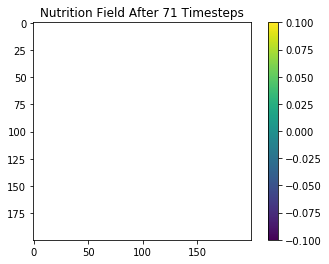

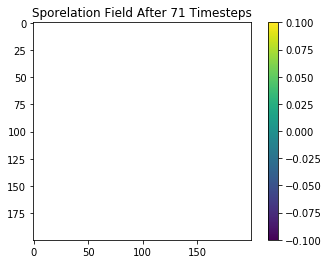

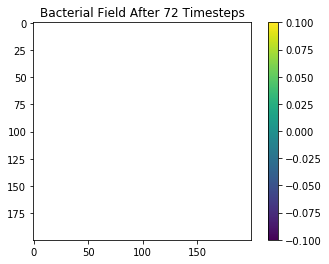

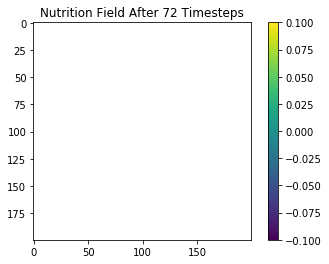

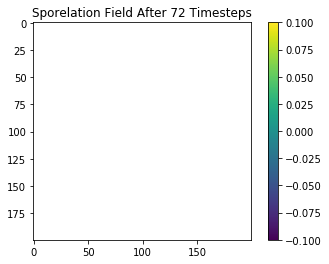

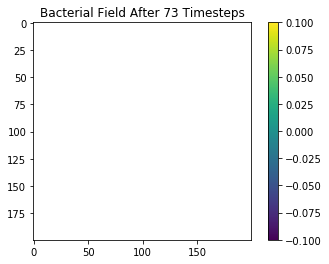

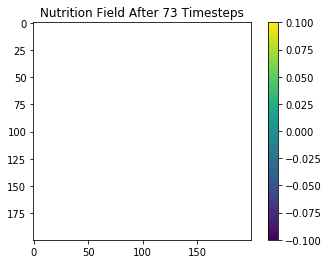

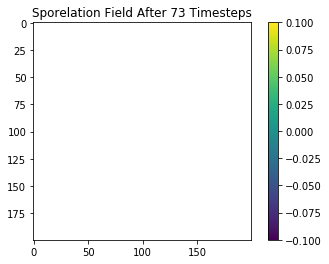

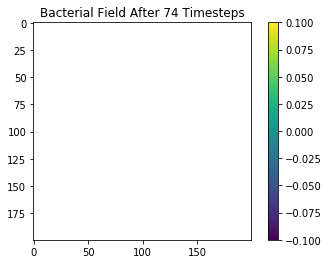

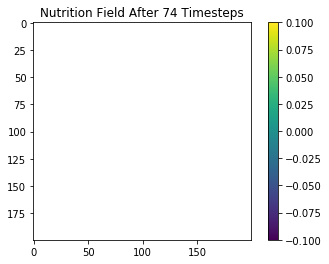

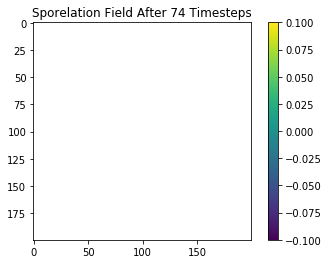

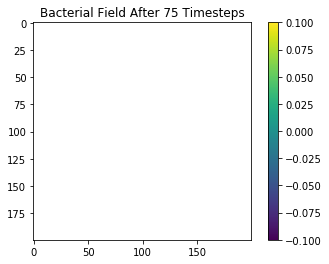

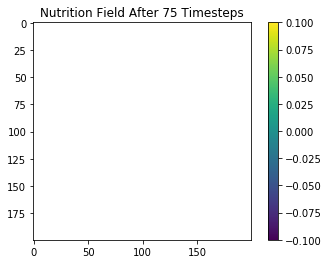

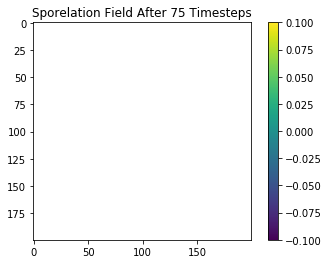

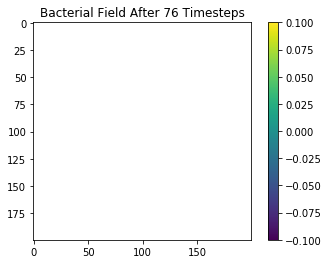

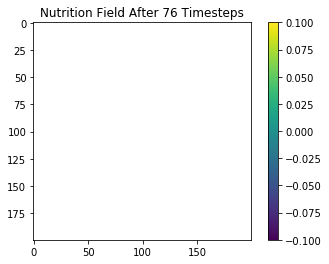

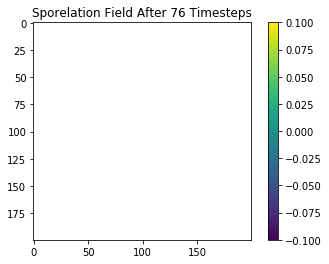

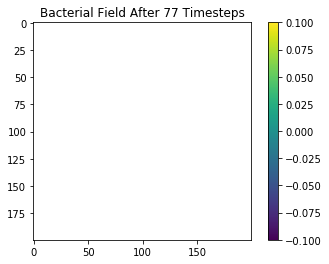

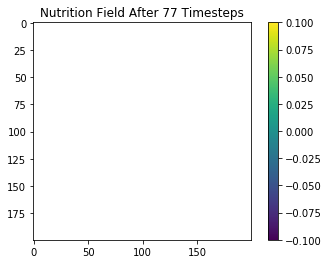

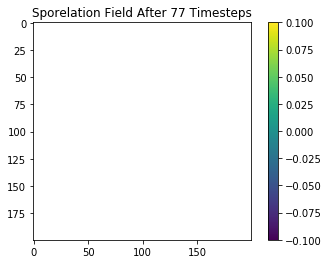

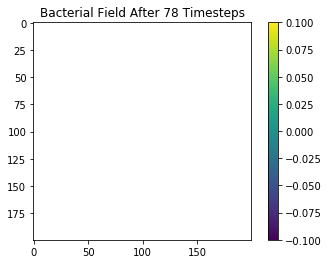

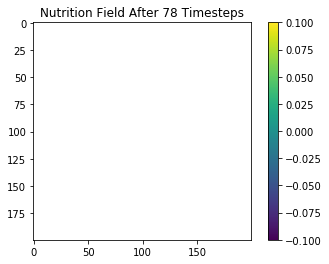

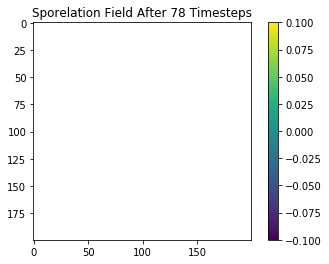

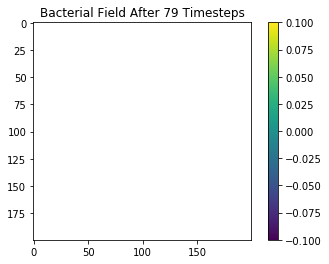

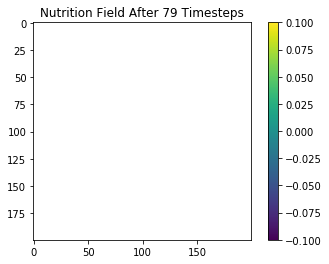

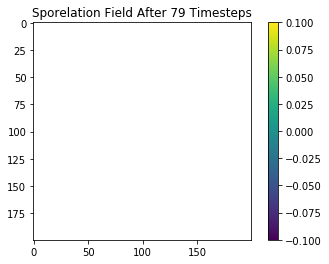

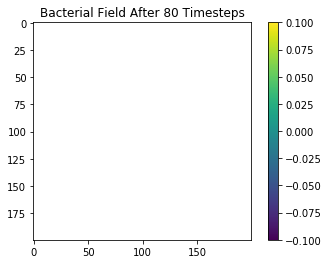

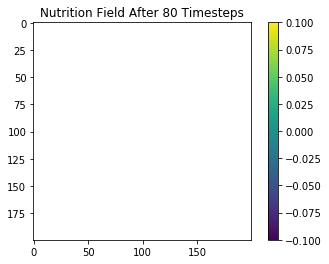

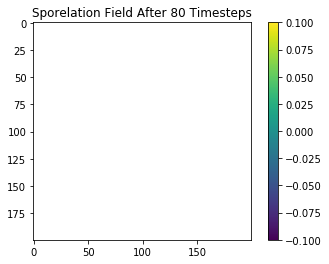

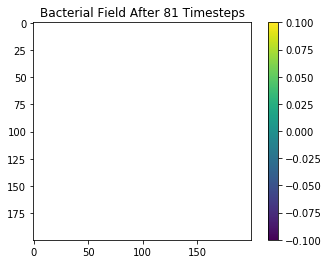

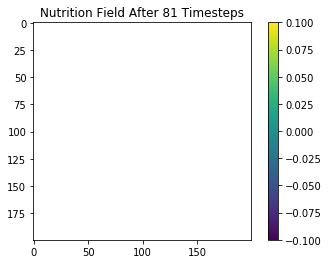

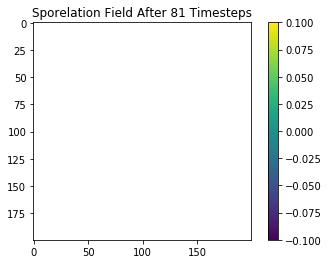

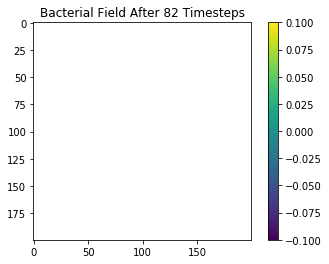

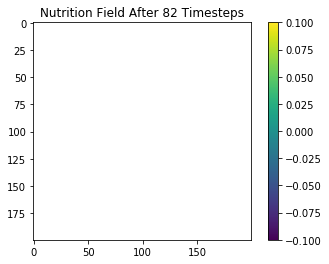

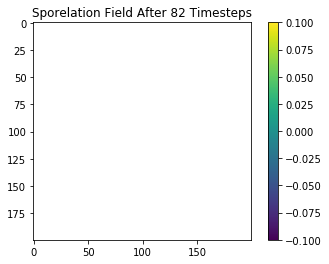

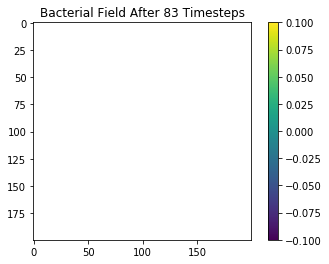

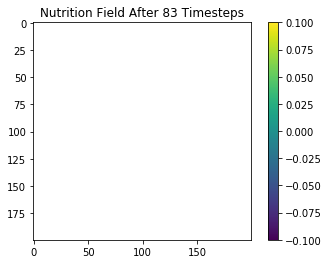

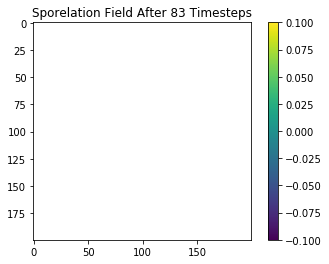

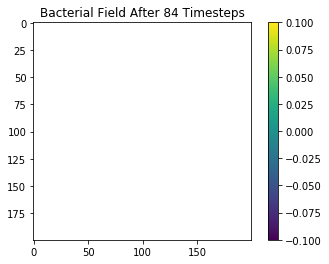

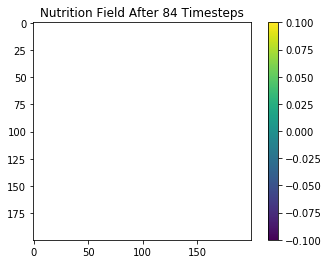

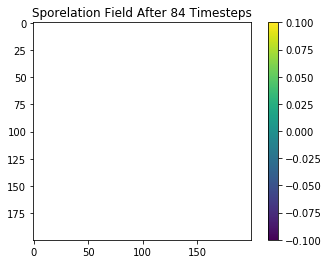

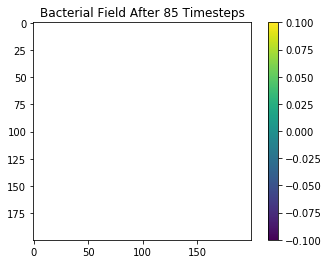

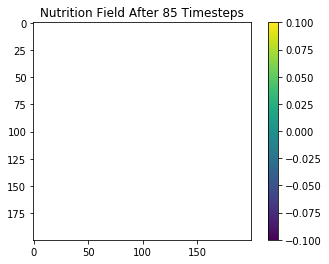

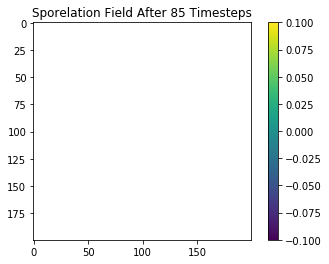

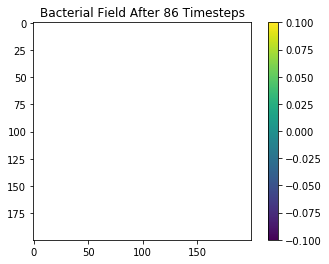

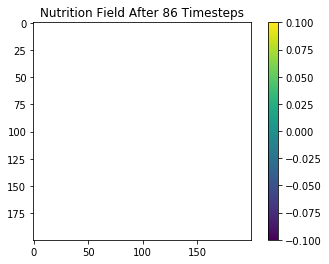

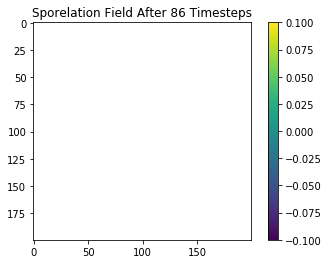

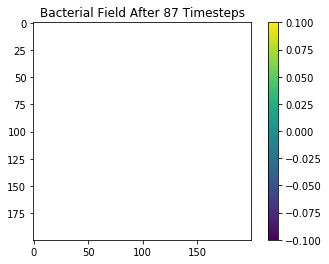

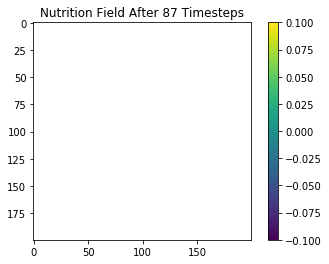

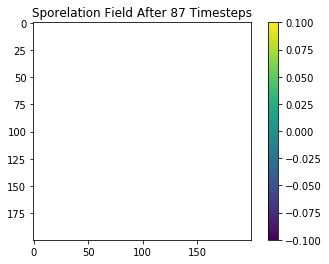

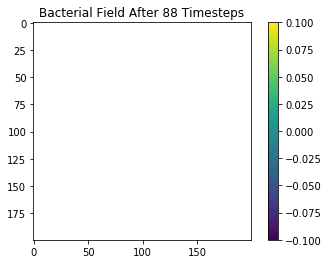

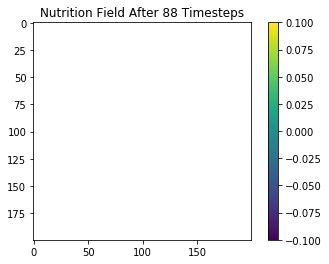

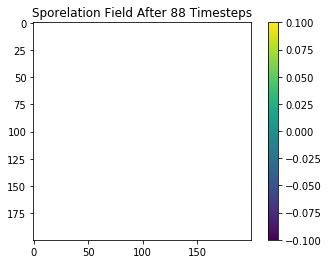

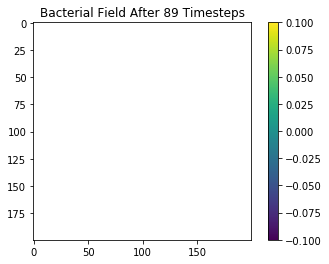

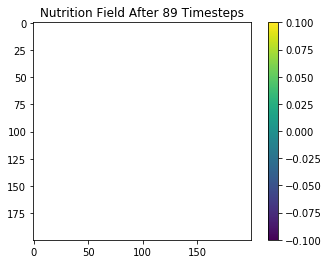

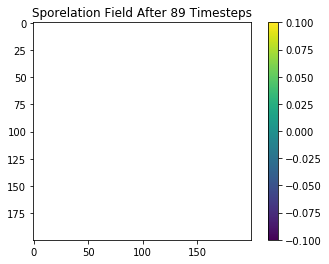

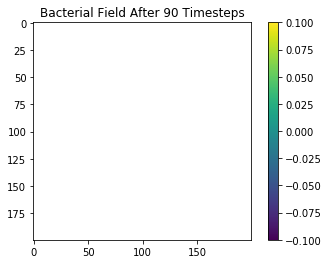

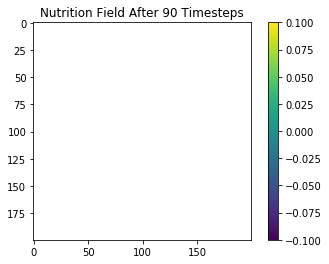

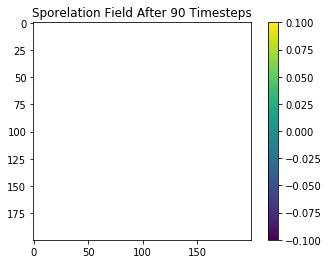

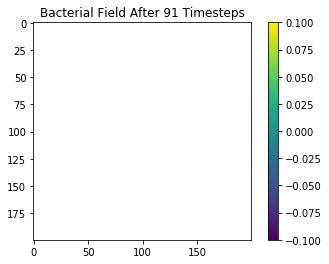

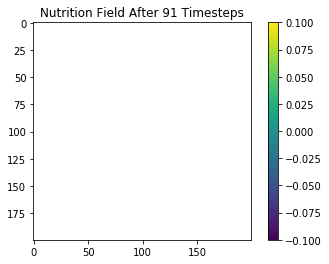

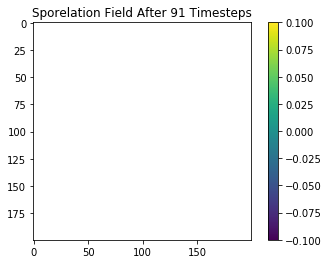

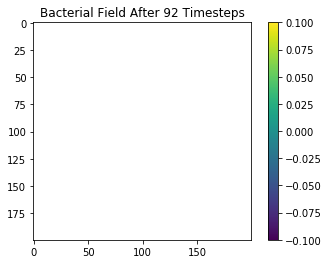

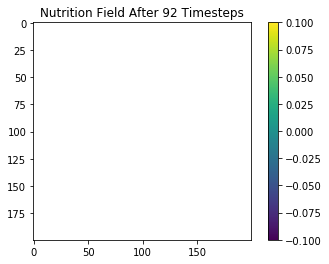

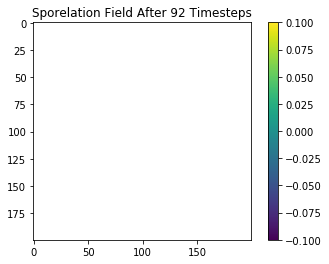

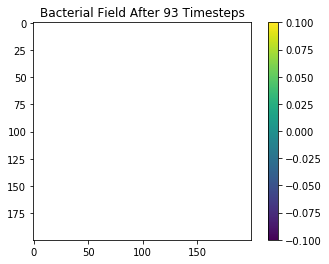

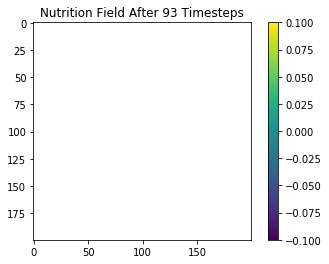

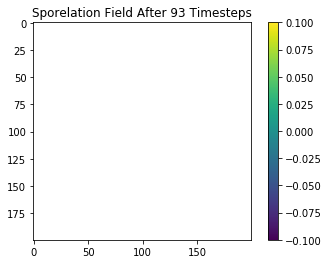

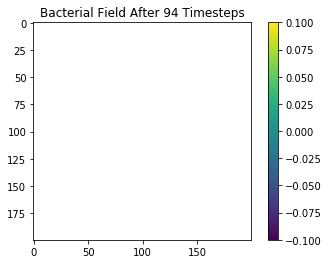

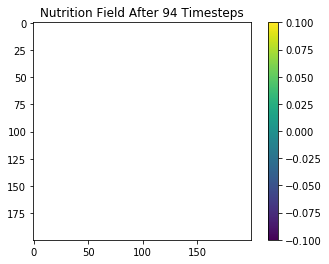

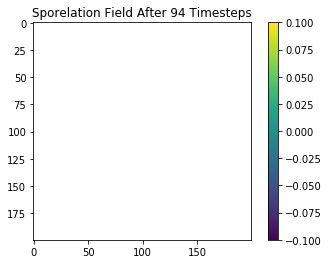

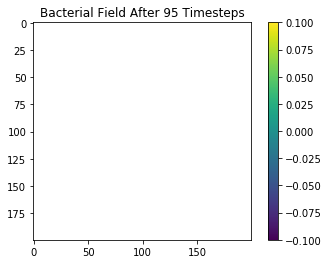

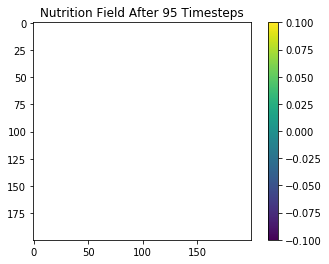

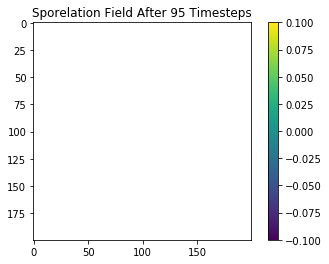

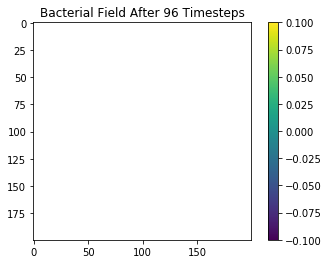

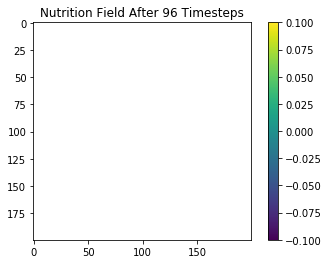

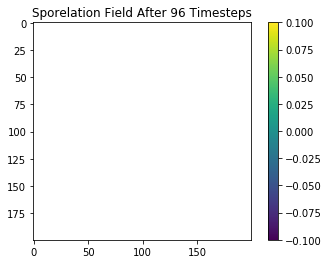

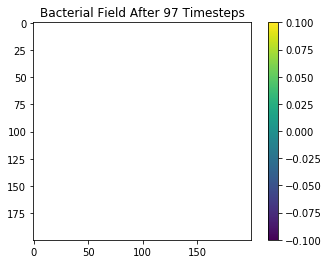

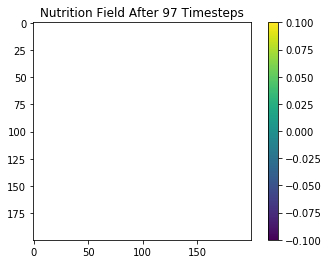

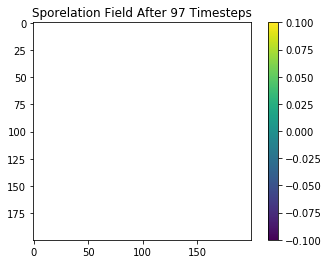

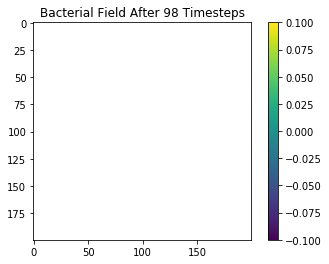

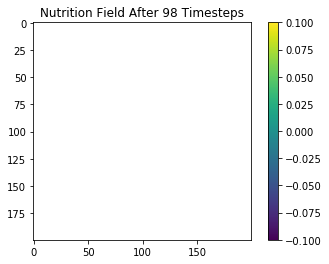

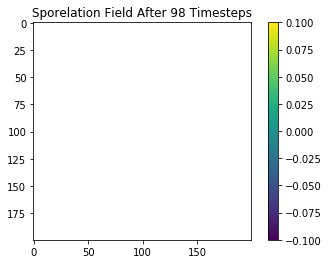

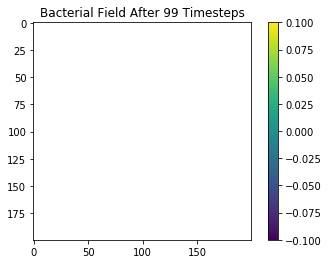

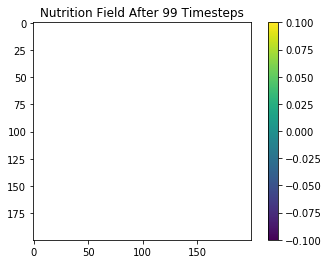

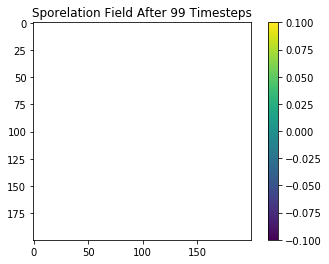

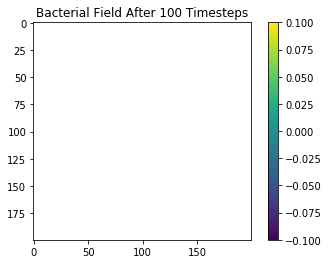

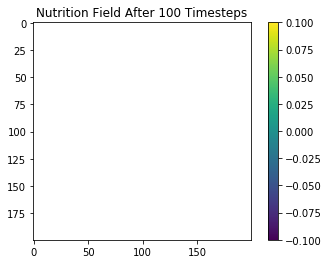

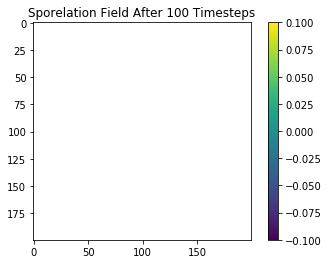

In [8]:
for i in range(num_updates):
    # cheaky thing here, if update in certain order only need copy of bac field
    oldbac = copy.deepcopy(bac)
    bac = NLDmBacteria(bac, nutr)
    nutr = NLDmNutrients(oldbac, nutr)
    spore = NLDmSporlation(oldbac, spore)
    no_neg(bac)
    no_neg(nutr)
    no_neg(spore)
    if i % update_interval == 0:
        draw(bac, 'Bacterial Field After ' + str(i + 1) + ' Timesteps')
        draw(nutr, 'Nutrition Field After ' + str(i + 1) + ' Timesteps')
        draw(spore, 'Sporelation Field After ' + str(i + 1) + ' Timesteps')